# Homework 1 (Total Points: 175)



Learning Goals:
- Learn how to load a dataset and process it.
- Learn how to implement several IR methods (TFIDF, BM25, QL) and understand their weaknesses & strengths.
- Learn how to evaluate IR methods


**NOTE 1**: Only the code (`TODO: Implement this!` denotes these sections) is graded. The 'theory' questions in this assignment serve as a preparation for the exam and to facilitate a deeper understanding of the course content. These questions (denoted by `TODO: Answer this!`) have no points assigned to them, but **need** to be filled out before submission.  

**NOTE 2**: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. 

**NOTE 3**: The notebook you submit has to have the student ids, seperated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 

**NOTE 4**: Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  

---
Additional Resources: 
-  Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)


In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.html import widgets
from collections import namedtuple, defaultdict

%matplotlib inline

/Users/berend/miniconda3/envs/ir1-hw1/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Section 1: Text Processing (20 points)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 

The following cell downloads the dataset and unzips it to a local directory

In [2]:
def download_dataset(folder_path = "./datasets/"):
    
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

You can see a brief description of each file in the dataset by looking at the README file

In [3]:
##### Read the README file 
!cat ./datasets/README
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query


----
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
!head -45 ./datasets/cacm.all
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1


---

Now, write a function to read in the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document

In [5]:
# TODO: Implement this! (4 points)
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/cacm" be default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (seperated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    
    filepath = os.path.join(root_folder, 'cacm.all')
    doc_ids = []
    documents = []
    
    with open(filepath, 'r') as f:
        docs = f.read().split('.I ')[1:]
    
    for doc in docs:
        lines = doc.split('\n')
        doc_id = int(lines[0])
        title = lines[lines.index('.T')+1]

        if '.W' in lines:
            start = lines.index('.W')+1
            end   = lines.index('.B')
            abstract = '\n'+'  '.join(lines[start:end])

        else:
            abstract = ''
        
        doc_ids.append(doc_id)
        documents.append(title + abstract)
        
    return list(zip(doc_ids, documents))

docs = read_cacm_docs()

In [6]:
##### 
assert len(docs) == 3204, "There should be exactly 3024 documents"
##### 

---

Next, let us read the queries. They are formatted similarly: 

In [7]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

Now, write a function to read in this file:

In [8]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" be default
        Returns: A list of 2-tuples: (query_id, query)
    """
    
    queries   = []
    filepath = os.path.join(root_folder, 'query.text')
    
    with open(filepath, 'r') as f:
        queries_unprocessed = f.read().split('.I')[1:]
        
    for q in queries_unprocessed:
        lines = q.split('\n')
        
        query_id = int(lines[0])
        
        start = lines.index('.W')+1
        end   = lines.index('.N') if '.A' not in lines else lines.index('.A')
        query = ' '.join(lines[start:end])
        
        queries.append((query_id, query))
        
    return queries
    
    
queries = read_queries()

In [9]:
##### 
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

---

Read in the stop words:

In [10]:
!head ./datasets/common_words

a
about
above
accordingly
across
after
afterwards
again
against
all


In [11]:
# TODO: Implement this! (3 points)
def load_stopwords(root_folder = "./datasets"):
    """
    Load the stopwords
    Output: A set of stopwords
    """
    
    filepath = os.path.join(root_folder, 'common_words')
    
    with open(filepath, 'r') as f:
        stopwords = set(f.read().split())
    
    return stopwords

stopwords = load_stopwords()
assert len(stopwords) == 428

--- 

We can now write some basic text processing functions. A first step is to tokenize the text. You may use any tokenizer available in the `nltk` library:

In [12]:
# TODO: Implement this! (5 points)
nltk.download('punkt')

def tokenize(text):
    """
        Tokenize the text. 
        Input: text - a string
        Output: a list of tokens
    """
    
    return nltk.tokenize.word_tokenize(text)
    

[nltk_data] Downloading package punkt to /Users/berend/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
#####
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)
print(tokens)
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---

*Answer the following questions*: 
- Why is stemming necessary, in particular for IR?
    - TODO: Answer this!
    - Stemming removes unnecessary information captures in suffixed and affixes, and keeps the information embedded in the stem. It makes the IR system more flexible and the IR task simpler as different word forms can be recognized as the same query word (which is stemmed as well). 
- Is there any setting (domain, scenario, etc) in which stemming can hurt performance? Illustrate with an example
    - *TODO: Answer this!*
    - Stemmers may generate false positives by overstemming (words that are stemmed to the same root while they should not have been), an example: university, universal and universe are all stemmed to "univers" (source: https://en.wikipedia.org/wiki/Stemming#Error_metrics). 
    - A domain which could suffer from errors in stemming would be a collection of medical texts. In medical texts, words with a Greek and Latin origin frequently occur. These words are conjugated differently than according to traditional English grammar. Example: Alumnus -> alumnu, alumni -> alumni, alumna -> alumna, this is an example of understemming. The word should have been stemmed to the same root, but they are not, as they do not follow standard English grammar. 
    Two different words may have the same without having the same semantical meaning. An example would be: 

Write a function to stem tokens. Again, you can use the `nltk` library for this

In [14]:
# TODO: Implement this! (5 points)
def stem_token(token):
    """
        Stem the given token, using any stemmer available from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    
    stemmer = nltk.stem.PorterStemmer()
    
    return stemmer.stem(token)
    

In [15]:
####
print([stem_token(t) for t in tokens])
tokens_ = [
    'caresses', 'flies', 'dies', 'mules', 'denied',
    'died', 'agreed', 'owned', 'humbled', 'sized',
    'meeting', 'stating', 'siezing', 'itemization',
    'sensational', 'traditional', 'reference', 'colonizer',
    'plotted']
print([stem_token(t) for t in tokens_])
####

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']
['caress', 'fli', 'die', 'mule', 'deni', 'die', 'agre', 'own', 'humbl', 'size', 'meet', 'state', 'siez', 'item', 'sensat', 'tradit', 'refer', 'colon', 'plot']


---

*Answer the following questions*: 
- Another processing step (not done here) is to use n-grams. Illustrate why you would want to use n-grams in IR with an example.  
    - *TODO: Answer this!*
    - Unigram models assume that words are independent from their neighbours. However, in natural language this is rarely the case. Using N-grams can enable us to capture dependencies in word sequences. An example we have seen in class is the query "Paris Hilton". If we take this query as two separate words, we may find a Hilton hotel in Paris. However, when we consider the bi-gram "Paris Hilton", it is clear that we are looking for the celebrity Paris Hilton. 
- Usage of n-grams exacerbates some problems ex. in bi-gram language models. What is this problem? Suggest one solution 
    - *TODO: Answer this!*
    - When considering bi-grams rather than unigrams, the probability of encountering a new (unseen) bi-gram is higher than when considering unigrams. A solution could be to use laplace-smoothing, or backoff and interpolation (if bi-gram is unseen, try using the unigrams). 

--- 

The following function puts it all together. Given a string, it tokenizes it, and processes it according to the flags that you set.

In [16]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

Let's create two sets of pre-processed documents

In [17]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text: stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 



We can now process the documents and queries according to the configuration specified above

In [18]:
####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

####


--- 

## Section 2: Indexing (10 points)


A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### Building an index

A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


---

In this assignment we will be using an index created in memory, since our dataset is tiny. To get started, build a simple index that maps simply counts the number of tokens present in a document. This index  is built using a python dictionary.

*Answer the following questions*:
- What is the time complexity of retrieving a list of documents from a python `dict` object? 
    - *TODO: Answer this!* 
    - Since Python's dictionaries use hash tables, a search of documents would have an average time complexity $O(1)$. 
- Consider the case with a 10 million documents. What is the time complexity of retrieval with an inverted index (assuming you can fit the entire index in memory)? (Hint: Consider length of a query $|q|$) 
    - *TODO: Answer this!*
    - First: q lookups in inverted index: $O(|q|)$. This yields k document IDs. Looking up the documents has a complexity of $k O(1)$. $kO(1) + O(|q|) = O(|q|)$. 
- For a large enough collection, we cannot store an index in memory. How is this tackled in practice (briefly explain)? Comment on the time complexity. 
    - *TODO: Answer this!*
    - The inverted list is split in several blocks that do fit in memory. Say we need B blocks to fit the entire list in memory, we would have to look up the query B times more.
- Mention a use-case in which a simple index (from word -> doc_id) might not suffice anymore. How would you modify the index to suit this use-case (if you can!)  
    - *TODO: Answer this!*
    - At some point, we migth want to index very large documents (e.g. books). Then, the fact that a term occurs in the document does not make it relevant per se. We can modify the index to contain counts or relative frequencies of the terms.
    
    
Now, implement a function to build an index:

In [19]:
# TODO: Implement this! 10 points
def build_tf_index(documents):
    """
    Build an inverted index (with counts). The output is a dictionary which takes in a token
    and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
    Input: a list of documents - (doc_id, tokens) 
    Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    
    index = defaultdict(list)
    
    for doc_id, doc in documents:
        tokens, counts = np.unique(doc, return_counts=True)
    
        for token, count in zip(tokens, counts):
            index[token].append((doc_id, count))
   
    return index
 
# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the correct index 
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

# This function correctly pre-processes the text given the index set
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)
    

--- 

## Section 3: Retrieval  (80 points)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- TF-IDF
- BM25
- Query Likelihood Models

--- 

### Ranking functions


Probably the simplest IR model is the Bag of Words (BOW) model. Implement a function that scores a query against a document using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

In [20]:
# TODO: Implement this! 10 points
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note #1: You have to use the `get_index` function created in the previous cells
        Note #2: You can binarize the counts if you wish to
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)    
    query = preprocess_query(query, index_set)

    # get query_terms and counts
    query_terms, query_counts = np.unique(query, return_counts=True)
        
    # init empty vectors
    vectors = defaultdict(lambda:[0] * len(query_counts))
    
    # init scores dict
    scores = {}
    
    # loop over query terms
    for i, term in enumerate(query_terms):
        for doc_id, c in index[term]:
            # set vector entry to term frequency in document
            vectors[doc_id][i] = c * query_counts[i]
    
    # calculate cos similarity
    for doc_id in vectors.keys():
        scores[doc_id] = np.dot(vectors[doc_id], query_counts) / (np.linalg.norm(vectors[doc_id])*np.linalg.norm(query_counts))
    
    # set doc scores for docs without query terms to 0 
    for doc_id, _ in docs:
        if doc_id not in scores.keys():
            scores[doc_id] = 0
    
    # back to list and sort
    scores = [(k,v) for k,v in scores.items()]
    scores = sorted(scores, key = lambda x: x[1], reverse=True)
    
    return scores

*Answer the following questions*: 
- The BOW model is might not be a good choice for use in IR. Why? 
    - BOW assumes independence between words, and also neglects word order. However, word order might have a significant effect on the meaning and intent of the query, and we might lose information if we disregard the word order.

In [21]:
%%time
####
docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
#### 

BOW Results:
Rank 0(1.0): ALGOL Sub-Committee Report - Extensions...
Rank 1(1.0): The Use of Computers in Engineering Classroom Inst...
Rank 2(1.0): Report on a Conference of University Computing Cen...
Rank 3(1.0): Report on the Algorithmic Language ALGOL 60...
Rank 4(1.0): SMALGOL-61\nPrior to and during the 1961 Western J...
CPU times: user 3.35 ms, sys: 1.39 ms, total: 4.75 ms
Wall time: 3.77 ms


Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

In [22]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    
    doc_freq = defaultdict(int)
    
    for document in documents:
        for token in set(document):
            doc_freq[token] += 1

    return doc_freq
            
            
        
# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]

Next, implement a function that computes a tf-idf score given a query.      

In [23]:
# TODO: Implement this! 10 points
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    df = get_df(index_set)
    query = preprocess_query(query, index_set)
    N = len(docs)
    
    # get query terms and their counts 
    query_terms, query_counts = np.unique(query, return_counts=True)
    
    # define empty vectors
    vectors = defaultdict(lambda:[0] * len(query_counts))
    
    #init score dict
    scores = {}

    # calculate the query vector
    query_vector = [c * np.log(N/df[term]) if df[term] != 0 else 0 for c, term in zip(query_counts, query_terms)]
    
    # loop over query terms and docs in inverted index
    for i, term in enumerate(query_terms):
        for doc_id, c in index[term]:
            # if term does not occur in doc, vector entry is 0
            if df[term] == 0:
                vectors[doc_id][i] = 0
            # else, vector entry is tf-idf
            else:
                vectors[doc_id][i] = c * query_counts[i] * np.log(N/df[term])
    
    # for each doc vector calculate cos similarity with query vector
    for doc_id in vectors.keys():
        scores[doc_id] = np.dot(vectors[doc_id], query_vector) / (np.linalg.norm(vectors[doc_id]) * np.linalg.norm(query_vector))
    
    # if doc does not contain query terms, set score to 0 
    for doc_id, _ in docs:
        if doc_id not in scores.keys():
            scores[doc_id] = 0
    
    # back to list and sort
    scores = [(k,v) for k,v in scores.items()]
    scores = sorted(scores, key = lambda x: x[1], reverse=True)

    return scores

In [24]:
####
test_tfidf = tfidf_search("report science", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf)
####

TFIDF Results:
Rank 0(1.0): The State of Computer Oriented Curricula in Busine...
Rank 1(1.0): The Technology of Computer Center Management: A\nM...
Rank 2(0.98): Rejuvenating Experimental Computer Science\nThis r...
Rank 3(0.95): Computational Linguistics in a Ph.D. Computer Scie...
Rank 4(0.9): Information Science in a Ph.D. Computer Science Pr...


*Answer the following questions*: 
- It is generally not advisable to use the naive version of tf-idf. Why?
    - *TODO: Answer this!*
    - The naive version of tf-idf does not take into account the document length, which might become problematic if some of the documents become very long (e.g. books), since the query terms are more likely to appear more often in those long documents. Furthermore, if the query term does not occur in any of the documents, we encounter divisions by 0.  
- Illustrate with an example why using a sublinear scaling for TF is preferable in some cases.  
    - *TODO: Answer this!*
    - Intuitively, we can explain this by the fact that the 100th occurence of a term in a document is not as significant as the first or second time. In other words, by using a sublinear scaling we decrease the marginal significance of term occurences when the frequency increases.

--- 

*Answer the following questions*: 
- An alternative way to compute a query<>document score is to vectorize both the query and document (where each dimension corresponds to a token), and compute a score. The score can be computed using a dot product between the query and the document vectors. Why is the cosine similary function a better choice, particularly in IR? 
    - **Answer**
    - The cosine similarity is preferred over the dot product, as the cosine similarity is normalized. In other words, the cosine similarity only cares about the angle of difference between the vectors, whereas the dot product also cares about the magnitude. 
- What is the time complexity of a search if we are using the vector space method mentioned in the previous question? What is the time complexity if we're using an index (assume that it fits in memory)? Assume $N$ is the number of documents and $|q|$ is the length of a query. 
    - **Answer**
    - Dot product algorithm: vectors A and B have length $|q|$, we multiply each $a_i$ and $b_i$, resulting in $|q|$ multiplications. Moreover, we add sum over all the previously computed products $a_i b_i$, which requires another $|q| - 1$ steps. In total, this would result in a time complexity of $O(|q|) + O(|q|) = O(|q|)$ per documents, with N documents: $N O(|q|) = O(N|q|)$. 

--- 

#### Query Likelihood Models

In this section you will implement a simple query likelihood model. 

First, let use implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 

**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

--- 

*Answer the following questions*: 
- Write down the formula for computing the query likelihood, assuming a multinomial unigram language model. 
    -     $p(d|q) = p(q|d)p(d)/p(q)$
    
    $p(q)$ is constant and $p(d)$ is assumed to be uniform. 
    
    Hence: $p(d|q) = p(q|d) = \prod_{i=1}^{|q|}p(t_{i}|d) = \prod_{i=1}^{|q|} \frac{c(t_{i},d)}{dl(d)}$
 
 
- What problem does this naive method have? Suggest a simple way to fix it.
    - The problem with this naive method is that the likelihood of a document will be 0 if one of the terms does not appear in the document. So, if $c(t_{i},d) = 0$, $p(d|q) = p(q|d) = 0$, whereas other words in the query might appear and a score of 0 would thus be inaccurate. A simple way to fix this is by implementing a smoothing method. The code below implements the Jelinek-Mercer smoothing method. This  method allows interpolation between document frequency and collection frequency. So instead of fully relying on the frequency of a term in a document, we also take into account how often the term occurs in the collection of documents. The hyperparameters $\alpha$ decides the weight assigned to both frequencies. 

In [25]:
####
def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [47]:

# TODO: Implement this! 15 points
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)
    doc_len = get_doc_lengths(index_set)
    query = preprocess_query(query, index_set)
    
    # get query counts and terms to calculate KL divergence
    query_terms, query_counts = np.unique(query, return_counts=True)
    query_len = sum(query_counts)
    epsilon = 1e-8
    
    # scores start at 0 
    scores = defaultdict(lambda:0)
    
    # loop over query terms 
    for i, term in enumerate(query_terms):
        # compute the likelihood of the term given the query
        term_llh_query = query_counts[i] / query_len
        for doc_id, c in index[term]:
            # compute the likelihood of the term given the doc
            term_llh_doc = c / doc_len[doc_id]
            # calculate the part of KL Divergence for this term in query and this doc, sum over terms
            scores[doc_id] += query_counts[i] * term_llh_query * np.log(term_llh_query / term_llh_doc)
    
    # inverse KL divergence, epsilon to avoid division by 0
    for doc_id in scores.keys():
        scores[doc_id] = 1 / (scores[doc_id] + epsilon)
    
    # for each document that did not have any of the query terms, set score to 0
    for doc_id, _ in docs:
        if doc_id not in scores.keys():
            scores[doc_id] = float(0)
    
    # back to list and sort
    scores = [(k,v) for k,v in scores.items()]
    scores = sorted(scores, key = lambda x: x[1], reverse=True)
            
    return scores

In [48]:
####
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_naiveql)
####

TFIDF Results:
Rank 0(0.62): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.62): A Report Writer For COBOL...
Rank 2(0.62): A CRT Report Generating System...
Rank 3(0.56): Supplement to the ALGOL 60 Report...
Rank 4(0.51): Report on the Algorithmic Language ALGOL 60...


Now, let's implement a (slightly more) complex QL model. This model should 'fix' the issue with the previous method. If your model requires hyperparameters, set a reasonable value. 

In [45]:
# TODO: Implement this! 20 points
def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a appropriate QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    doc_len = get_doc_lengths(index_set)
    query = preprocess_query(query, index_set)
    
    # total number of terms in collection for smoothing
    C = sum(doc_len.values())
    
    # get query counts and terms to calculate KL divergence
    query_terms, query_counts = np.unique(query, return_counts=True)
    query_len = sum(query_counts)
    epsilon = 1e-8
    
    # scores start at 0
    scores = defaultdict(lambda:0)

    freq_dict = dict()
    for i, term in enumerate(query_terms):
        # calculate collection frequency of term for smoothing
        freq_dict[term] = sum([c for i,c in index[term]])
        # compute term likelihood given the query
        term_llh_query = query_counts[i] / query_len
        for doc_id, c in index[term]:
            # calculate p(t|d) with Jelinek Mercer smoothing (interpolation)
            ptd = alpha * c / doc_len[doc_id] + (1 - alpha) * freq_dict[term] / C
            # calculate the part of KL Divergence for this term in query and this doc, sum over terms
            scores[doc_id] += query_counts[i] * term_llh_query * np.log(term_llh_query / ptd)

    # Inverse KL divergence for ranking, add epsilon to avoid division by 0
    for doc_id in scores.keys():
        scores[doc_id] = 1 / (scores[doc_id] + epsilon)
    
    # set score to 0 for each doc without any query terms
    for doc_id, _ in docs:
        if doc_id not in scores.keys():
            scores[doc_id] = float(0)
    
    # back to list and sort
    scores = [(k,v) for k,v in scores.items()]
    scores = sorted(scores, key = lambda x: x[1], reverse=True)
            
    return scores

In [53]:
#### Test the QL model
alpha = 0.7
test_ql_results = ql_search("report"
                            , index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(0.51): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.51): A Report Writer For COBOL...
Rank 2(0.51): A CRT Report Generating System...
Rank 3(0.47): Supplement to the ALGOL 60 Report...
Rank 4(0.43): Report on the Algorithmic Language ALGOL 60...

Rank 0(0.051): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.051): A Report Writer For COBOL...
Rank 2(0.051): A CRT Report Generating System...
Rank 3(0.047): Supplement to the ALGOL 60 Report...
Rank 4(0.043): Report on the Algorithmic Language ALGOL 60...


*Answer the following questions*: 
- What happens to the query likelihood for long queries? What is a simple fix for this issue?
    - *TODO: Answer this!*
    - If the query becomes very long, the likelihood of the query diminishes, as terms $< 1$ are multiplied. In the end this leads to very low scores, possibly ~0 if the query is extremely long. This might lead to numerical instabilities, which makes the ordering of the ranking problematic. A simple fix for this would be to take the log of the probabilities.


--- 

#### BM25

In this section, we will implement the widely used and hard to beat BM25 scoring function. 


In [49]:
# TODO: Implement this! (20 points)
k1 = 1.2
b = 0.75
N = len(docs)

def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. 
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    # retrieve index and doc lengths 
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    dl_avg = np.mean(list(doc_lengths.values()))
    
    # preprocess the query
    query = preprocess_query(query, index_set)
    
    # init score dict
    scores = {}
    
    # get document frequencies
    df = get_df(index_set)
    
    # initialize all scores at 0
    for doc_id, _ in docs:
        if doc_id not in scores.keys():
            scores[doc_id] = 0
    
    # find relevant documents by scanning the index on the terms in the query
    for term in query:
        # for all the docs in which the term occurs, compute the score. 
        for doc_id, c in index[term]:
            dl = doc_lengths[doc_id]
            # compute score according to BM25 formula.
            scores[doc_id] += np.log(N/df[term]) * (((k1 + 1) * c) /
                                                    (k1 * ((1-b) + b * (dl/dl_avg)) + c))
    # back to list and sort
    scores = [(k,v) for k,v in scores.items()]
    ranking = sorted(scores, key = lambda x: x[1], reverse=True)
     
    return ranking # this is a list of tuples, ranked on relevance (doc_id, score)

In [51]:
#### Test the BM25 model
test_bm25_results = bm25_search("science", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(7.1): Value Orientation of Computer Science Students\nTe...
Rank 1(7.1): A University's Educational Program in Computer Sci...
Rank 2(7.0): A Survey of Computer Science Offerings In Small Li...
Rank 3(6.7): Information Science in a Ph.D. Computer Science Pr...
Rank 4(6.6): The Practical Aspect of Computer Science Education...




*Answer the following questions*: 
- Briefly explain how the BM25 model improves upon the tf-idf model.
    - *TODO: Answer this!*
    - The BM25 model takes into account the relative document length and compensates for that (shorter documents are as likely to be relevant than long documents. 
    
---

In [33]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

---
---

The widget below allows you to play with the search functions you've written so far. This can be used, for example, to answer some of the theory questions

In [34]:
# Set this to the function you want to test
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

## Section 4: Offline Evaluation (45 points)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision
2. Recall
3. Mean Average Precision
4. Expected Reciprocal Rank

---
*Answer the following questions*: 
- What are the main limitations of an offline evaluation?
    - *TODO: Answer this!*
    - Creating a test collection is very labour intensive, as we need to (practically) guarantee that everything the algorithm might come up with in the ranking is labeled in terms of relevance. This labeling should be done by humans and is therefore costly.

---

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [35]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


The first column is the `query_id` and the second column is the `document_id`. You can safely ignore the 3rd and 4th columns. Write a function to read in the file: 

In [36]:
# TODO: Implement this!
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    output = {}
    filepath = os.path.join(root_folder, 'qrels.text')
    
    with open(filepath, 'r') as f:
        lines = f.read().splitlines()

    for line in lines:
        query_id, doc_id, _, _ = line.split()

        query_id = int(query_id)
        doc_id = int(doc_id)

        if query_id not in output:    
            output[query_id] = [doc_id]
        else:
            output[query_id].append(doc_id)
            
    return output
    

qrels = read_qrels()

In [37]:
####
assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

Now, implement the metrics below. 

**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


In [38]:
# TODO: Implement this! (10 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    pred_doc_ids = [doc_id for doc_id, _ in results[:k]]
    correct = len(set(relevant_docs) & set(pred_doc_ids))
    
    return correct/len(relevant_docs)
    
    
    
# TODO: Implement this! (10 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    
    pred_doc_ids = [doc_id for doc_id, _ in results[:k]]
    correct = len(set(relevant_docs) & set(pred_doc_ids))
    
    return correct / k
    
    

# TODO: Implement this! (10 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    
    ap = 0
    
    for i, (doc_id, _) in enumerate(results):
        if doc_id in relevant_docs:
            ap += precision_k(results, relevant_docs, i+1)
            
    return ap / len(relevant_docs)
            


# TODO: Implement this! (15 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """
    # g is a boolean array indicating relevance
    g = np.array([doc_id in relevant_docs for doc_id, _ in results], dtype=int)
    R_g = (np.power(2, g)-1) / np.power(2, g.max())
    n = len(results)
    prod = np.cumprod(1-R_g)
    prod = np.insert(prod, 0, 1)[:-1]
    err = 1 / np.arange(1, n+1) * prod * R_g
    return err.sum()
####

*Answer the following questions*: 
- What are the main drawbacks of precision & recall?
    - *TODO: Answer this!*
    - Usually there is trade-off between precision and recall: are false positives or false negatives preferred for the problem setting? Furthermore, the scores on precision and recall are meaningless without the fraction of relevant documents in the collection, i.e. if almost none of the documents is relevant, the algorithm can predict non-relevance for all the documents and have a high precision. The other way around where most of the documents are relevant, and the model predicts all the documents as relevant, it has a high recall and precision, but has no discriminative power whatsoever. The most important drawback for information retrieval is that precision and recall do not take into account the ranking of the documents in the ranking (both consider the complete ranking, but not the order). This problem is partly solved by Precision@k and Recall@k, but even those metrics do not take into account the order within the top $k$.
- What problems with Precision@K does Average Precision solve? 
    - *TODO: Answer this!*
    - Precision@$k$ still does not take into account the order of the documents within the top $k$ of the ranking. Average Precision does, by taking the average over all the relevant documents, thereby rewarding highly ranked relevant documents and penalizing the low ranked relevant documents (in the whole ranking). 
- The CACM dataset has *binary* relevance judgements. However, a more suitable way of assigning judgements is to use graded relevance. Mention a metric which might be more suitable for a graded relevance, and briefly explain why. 
    - *TODO: Answer this!*
    - An example of a metric that uses graded relevance is Discounted Cumulative Gain (DCG). In DCG, the relevance is based on the gain of examing the document, which is a graded scale. The relevance is scaled by a discount term, which is positively correlated with the rank $r$ (where the top document in the ranking has rank $r=1$).
- Consider a text processing step: stemming. What effect does this have on metrics? (Hint: Try changing the pre-processing config and try it out!)
    - *TODO: Answer this!*
    - When we compare stemmed vs. non-stemmed text (by changing the 2 configs (both lowercase=True, remove_stopword=False, one with stemming and one without) and running the notebook) we see that all the search functions get the same or higher scores on all metrics in case of stemming, proving that stemming indeed is beneficiary for the search process. 

---

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [39]:
####
recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [40]:
####
def evaluate_search_fn(search_fn, metric_fn, index_set):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = np.zeros(len(qrels), dtype=np.float32)
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        results = search_fn(query, index_set)
        metrics[i] = metric_fn(results, relevant_docs)
    
    return metrics.mean()
####

In [41]:
index_sets = {1, 2}

list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]

list_of_search_fns = [
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search)
]


results = {}
for index_set in index_sets:
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = {}
        for metric_name, metric_fn in list_of_metrics:
            r = evaluate_search_fn(search_fn, metric_fn, index_set).mean()
            print(f"\t\tMetric: {metric_name}: {r}")
            results[index_set][search_fn_name][metric_name] = r
        print()

Index: 1
	Evaluating Search Function: NaiveQL
		Metric: ERR: 0.014969581738114357
		Metric: MAP: 0.00882741529494524
		Metric: Recall@1: 0.0
		Metric: Recall@5: 0.0039143553003668785
		Metric: Recall@10: 0.0039143553003668785
		Metric: Precision@1: 0.0
		Metric: Precision@5: 0.011538461782038212
		Metric: Precision@10: 0.005769230891019106

	Evaluating Search Function: QL
		Metric: ERR: 0.014164397493004799
		Metric: MAP: 0.008394192904233932
		Metric: Recall@1: 0.0
		Metric: Recall@5: 0.004429464694112539
		Metric: Recall@10: 0.004429464694112539
		Metric: Precision@1: 0.0
		Metric: Precision@5: 0.011538461782038212
		Metric: Precision@10: 0.005769230891019106

	Evaluating Search Function: BM25
		Metric: ERR: 0.40404170751571655
		Metric: MAP: 0.23765285313129425
		Metric: Recall@1: 0.09718325734138489
		Metric: Recall@5: 0.22063495218753815
		Metric: Recall@10: 0.273042768239975
		Metric: Precision@1: 0.557692289352417
		Metric: Precision@5: 0.307692289352417
		Metric: Precision@10: 

## Section 5: Results and Analysis (20 points)

The `results` dictionary contains the results for all search functions we implemented. Plot the results in bar charts, with clear labels:

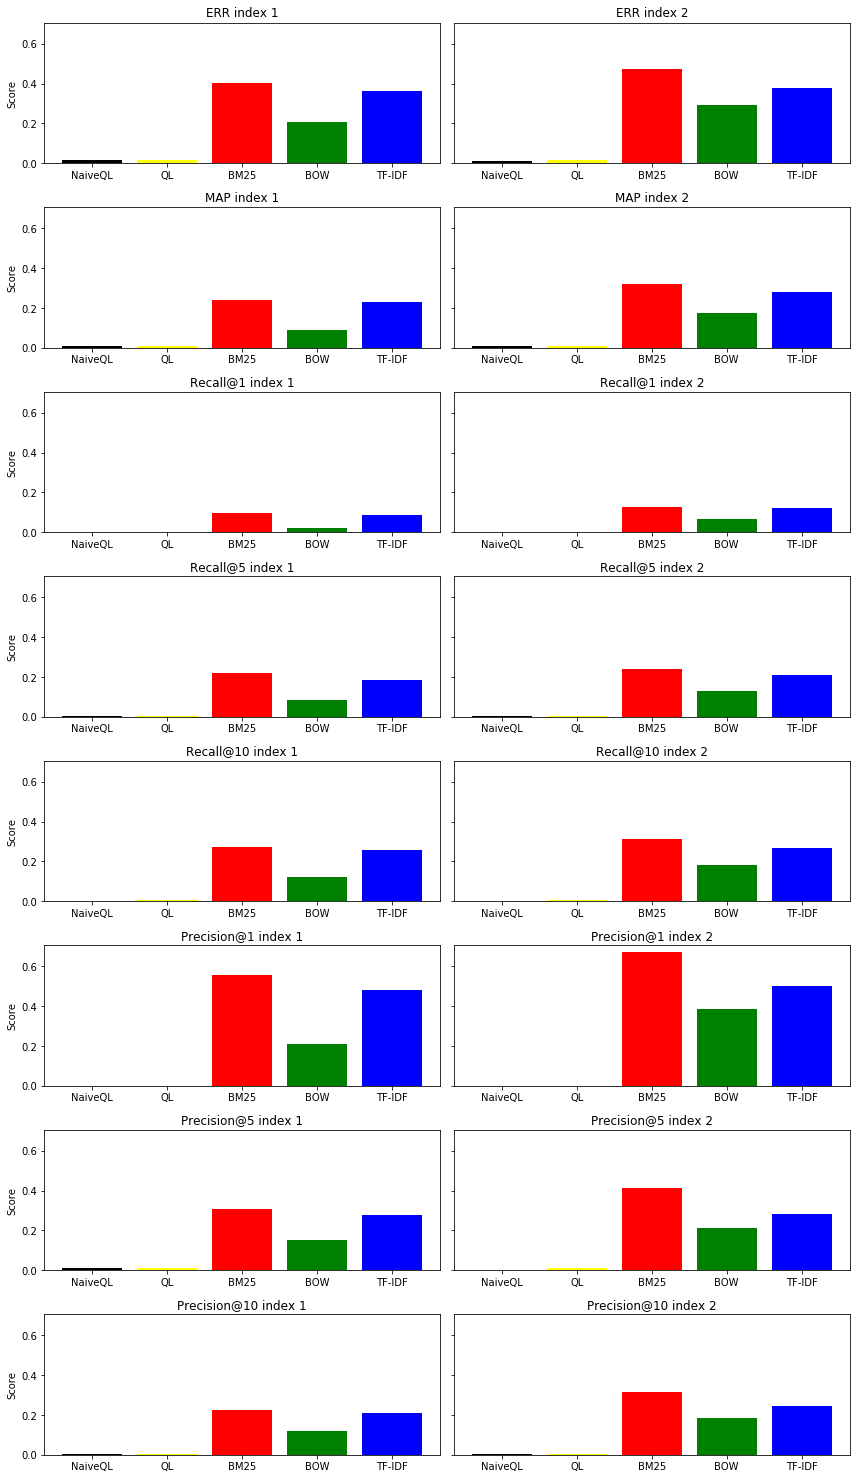

In [43]:
# The bar plots made in this cell show the performance of all models on both indices side to side. 

my_colors = ['black','yellow', 'red', 'green', 'blue']

# create labels for search functions
search_fn_labels = [search_fn for search_fn in results[1]]
metric_labels = ["ERR", "MAP", "Recall@1", "Recall@5", "Recall@10", "Precision@1", "Precision@5", "Precision@10"]

# get results per index
index1_results = results[1]
values_1 = [[index1_results[search_fn][metric] for metric in index1_results[search_fn]] for search_fn in index1_results]
# this is a list of lists in which the sublists are results per metric, for the search_fns in search_fn_labels
results_per_metric_1 = [list(x) for x in zip(*values_1)] 

index2_results = results[2]
values_2 = [[index2_results[search_fn][metric] for metric in index2_results[search_fn]] for search_fn in index2_results]
# this is a list of lists in which the sublists are results per metric, for the search_fns in search_fn_labels
results_per_metric_2 = [list(x) for x in zip(*values_2)] 



# define subplot
fig, axs = plt.subplots(8, 2, figsize=(15, 7), sharey=True)

for i, metric_values in enumerate(zip(results_per_metric_1, results_per_metric_2)):
    
    score_1, score_2 = metric_values
    axs[i][0].bar(search_fn_labels, score_1, color=my_colors)
    axs[i][0].set_title(metric_labels[i]+" index 1")
    axs[i][0].set_ylabel("Score")
    axs[i][0].grid()
    axs[i][1].bar(search_fn_labels, score_2, color=my_colors)
    axs[i][1].set_title(metric_labels[i]+" index 2")
    axs[i][1].grid()

fig.tight_layout(rect=[0, 0.05, 0.8, 3])
plt.show()



Write a summary of what you observe in the results.
You summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      
*Hint*: You may build upon the answers from the previous sections. 

*TODO: Answer this!*

# Conclusion
Above the scores on the different metrics for all the models are shown. First we will formulate a conclusion on the different search functions and their performance. Afterwards, the differences between the 2 indices will be dicsussed, and finally we will choose the best search engine based on these metrics.

## Search function performance
First of all we can see in the results that both the Query Likelihood (QL) models stay behind in terms of performance, and they perform worse than we expected. Also there is barely any improvement from the naive to the QL model that uses smoothing, which was expected. We suspect there might be a bug in the QL search algorithms, but did not manage to figure out what is causing the bad performance. 

-- hier iets zeggen over recall dan moeten we het aantal relevante documenten meenemen, de scores zijn laag maar misschien zijn er enorm veel relevante documenten. 

## Differences between indices
In the second index, the words are stemmed and stop words are removed. The results show that this boosts performance of all models, on all metrics. From this, we can draw the conclusion that stemming and stopword removal indeed facilitate the search process. 

Overall, the $BM25$ model is superior on all performance metrics (on both indices), and benefits the most from text preprocessing (stemming and stop word removal). For the hyperparameters $k_1$ and $b$ we used typical values found in literature, so possibly tuning could improve the performance even further. Using the default model, the precision at 1 is quite high at $0.6$, and an average precision of $0.3$. 